In [44]:
import os
import torch
import numpy as np
from pprint import pprint
from dataclasses import dataclass, asdict
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

import torch.nn.functional as F

from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig,BasicPipelineConfig
from conditional_rate_matching.data.states_dataloaders_config import StatesDataloaderConfig
from conditional_rate_matching.data.dataloaders_utils import get_dataloaders_crm
from conditional_rate_matching.models.trainers.call_all_trainers import call_trainer

from conditional_rate_matching.configs.config_files import ExperimentFiles

from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig
from conditional_rate_matching.configs.configs_classes.config_crm import CRMTrainerConfig

from conditional_rate_matching.models.trainers.crm_trainer import CRMTrainer

from conditional_rate_matching.models.trainers.crm_trainer import CRMDataloder
from conditional_rate_matching.models.pipelines.thermostat.crm_thermostat_config import ConstantThermostatConfig,LogThermostatConfig


from conditional_rate_matching.models.metrics.crm_loglikelihood import calculate_batch_log_likelihood,rate_to_probabilities
from conditional_rate_matching.models.metrics.crm_loglikelihood import get_log_likelihood

from torch.distributions import Categorical,Dirichlet

from conditional_rate_matching.models.temporal_networks.temporal_networks_config import (
    TemporalMLPConfig,
    TemporalDeepMLPConfig
)

In [45]:
from conditional_rate_matching.utils.plots.histogram_colors_plots import (
    plot_time_series_histograms,
    get_conditional_histograms_paths,
    categorical_counts_per_path,
    categorical_histogram_dataloader,
    plot_histograms_pairs
)

In [46]:
N = 3
alpha = 0.5
dirichlet_alpha = torch.full((N,),alpha)
stationary_0 = Dirichlet(dirichlet_alpha).sample((1,)).T
stationary_1 = Dirichlet(dirichlet_alpha).sample((1,)).T

In [74]:
config = CRMConfig()
config_b = CRMConfig()

gamma = .5
vocab_size = 4
dimensions = 2
num_grid_points = 100
dirichlet_alpha = .3
number_of_steps = 100

t_grid = torch.linspace(0.,1.,num_grid_points)
config.data0 = StatesDataloaderConfig(dimensions=dimensions,vocab_size=vocab_size)
config.data1 = StatesDataloaderConfig(dirichlet_alpha=dirichlet_alpha,
                                      dimensions=dimensions,vocab_size=vocab_size,
                                      total_data_size=1000,test_size=0.1)
config.pipeline = BasicPipelineConfig(number_of_steps=number_of_steps)
config.thermostat = ConstantThermostatConfig(gamma=gamma)
config.trainer = CRMTrainerConfig(number_of_epochs=200,learning_rate=1e-3)
config.temporal_network = TemporalMLPConfig(hidden_dim=250)

crm = CRM(config=config)

config_b.data0 = config.data1
config_b.data1 = config.data0
config_b.pipeline = config.pipeline
config_b.thermostat = config.thermostat
config_b.trainer = config.trainer
crm_b = CRM(config=config_b)

crm_b.dataloader_0 = crm.dataloader_1
crm_b.dataloader_1 = crm.dataloader_0

crm_b.pipeline.dataloder_0 = crm.dataloader_1
crm_b.pipeline.dataloder_1 = crm.dataloader_0

In [75]:
databatch1 = next(crm.dataloader_1.train().__iter__())
x_1 = databatch1[0]
databatch0 = next(crm.dataloader_0.train().__iter__())
x_0 = databatch0[0]

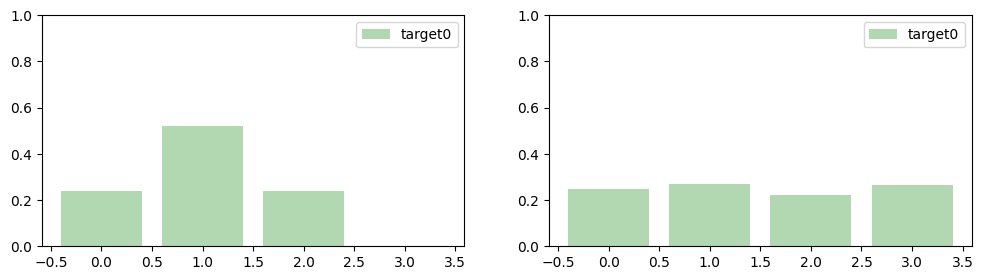

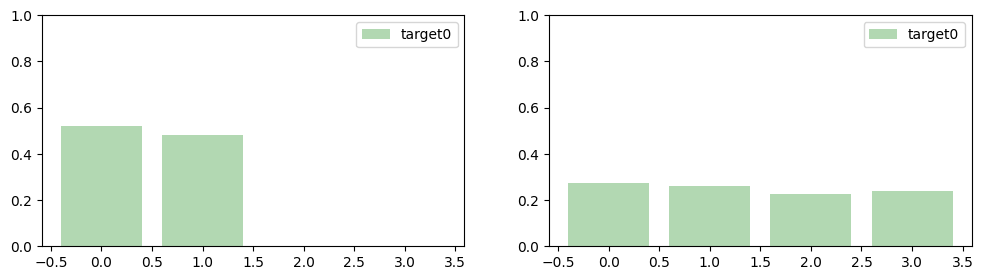

In [76]:
hist0_b = categorical_histogram_dataloader(crm_b.dataloader_0, dimensions, vocab_size, train=True,maximum_test_sample_size = 2000)
hist1_b = categorical_histogram_dataloader(crm_b.dataloader_1, dimensions, vocab_size, train=True,maximum_test_sample_size = 2000)

plot_histograms_pairs(hist0_b[0],hist1_b[0])
plot_histograms_pairs(hist0_b[1],hist1_b[1])

## Check Before Training

In [77]:
x_f, x_path, t_path = crm.pipeline(sample_size=500,return_path=True)
x_f, x_path_b, t_path_b = crm_b.pipeline(sample_size=500,return_path=True)

0it [00:00, ?it/s]

100it [00:00, 243.40it/s]
100it [00:00, 232.25it/s]
100it [00:00, 189.21it/s]
100it [00:00, 254.94it/s]
100it [00:00, 234.98it/s]
100it [00:00, 230.80it/s]
100it [00:00, 186.90it/s]
100it [00:00, 250.73it/s]


In [78]:
generative_histogram = categorical_counts_per_path(x_path,dimensions=dimensions,vocab_size=vocab_size,normalize=True)
generative_histogram_b = categorical_counts_per_path(x_path_b,dimensions=dimensions,vocab_size=vocab_size,normalize=True)
conditional_histograms_paths = get_conditional_histograms_paths(crm,t_grid)

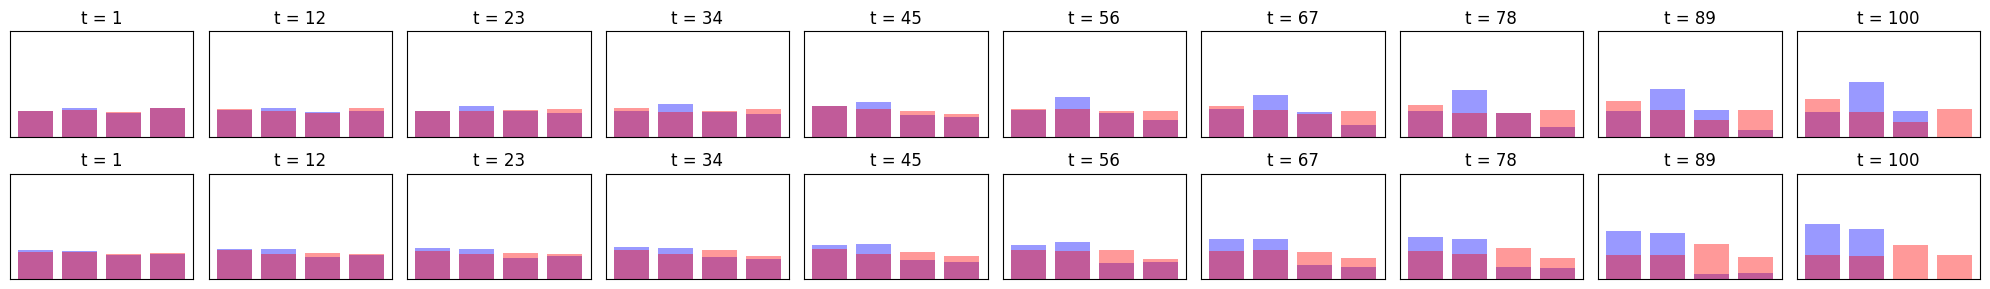

array([ 0, 11, 22, 33, 44, 55, 66, 77, 88, 99])

In [79]:
plot_time_series_histograms(conditional_histograms_paths,generative_histogram,num_timesteps_to_plot=10,figsize_tuple=(20, 3),plot_path=None)

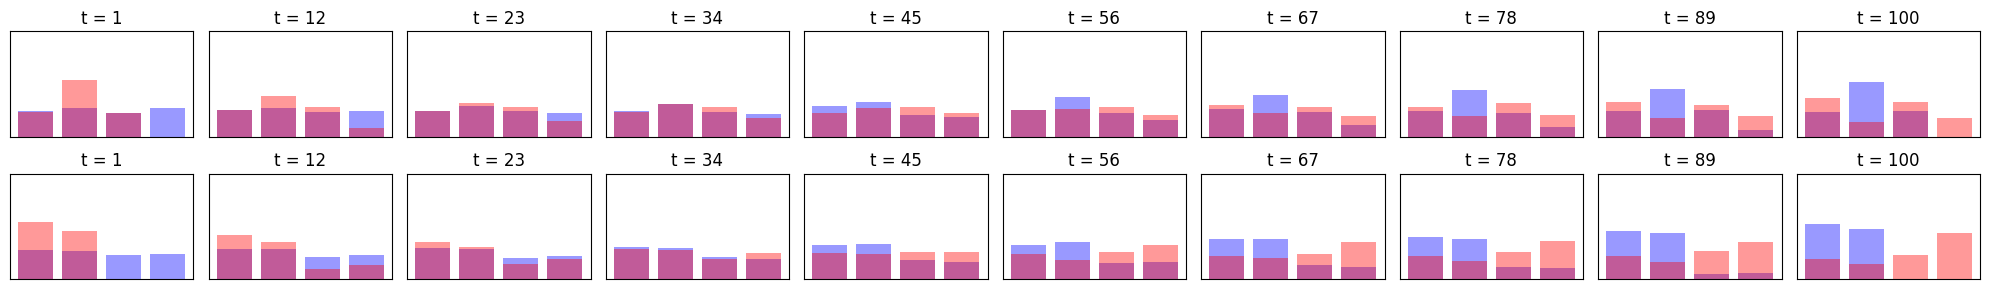

array([ 0, 11, 22, 33, 44, 55, 66, 77, 88, 99])

In [80]:
plot_time_series_histograms(conditional_histograms_paths,generative_histogram_b,num_timesteps_to_plot=10,figsize_tuple=(20, 3),plot_path=None)

# Train

In [81]:
experiment_files = ExperimentFiles(experiment_name="prenzlauer_experiment",
                                   experiment_type="colors_log_likelihood",
                                   experiment_indentifier="forward")
crm.experiment_files = experiment_files

experiment_files_b = ExperimentFiles(experiment_name="prenzlauer_experiment",
                                     experiment_type="colors_log_likelihood",
                                     experiment_indentifier="backward")
crm_b.experiment_files = experiment_files_b

### Train forward

# ==================================================
# START OF TRAINING 
# ==================================================
# Current Model ************************************
colors_log_likelihood
prenzlauer_experiment
forward
# ==================================================
# Number of Epochs 200
# ==================================================


Epoch 200, Loss: 0.9464: 100%|██████████| 200/200 [02:56<00:00,  1.13it/s]
100it [00:00, 336.92it/s]
100it [00:00, 374.63it/s]


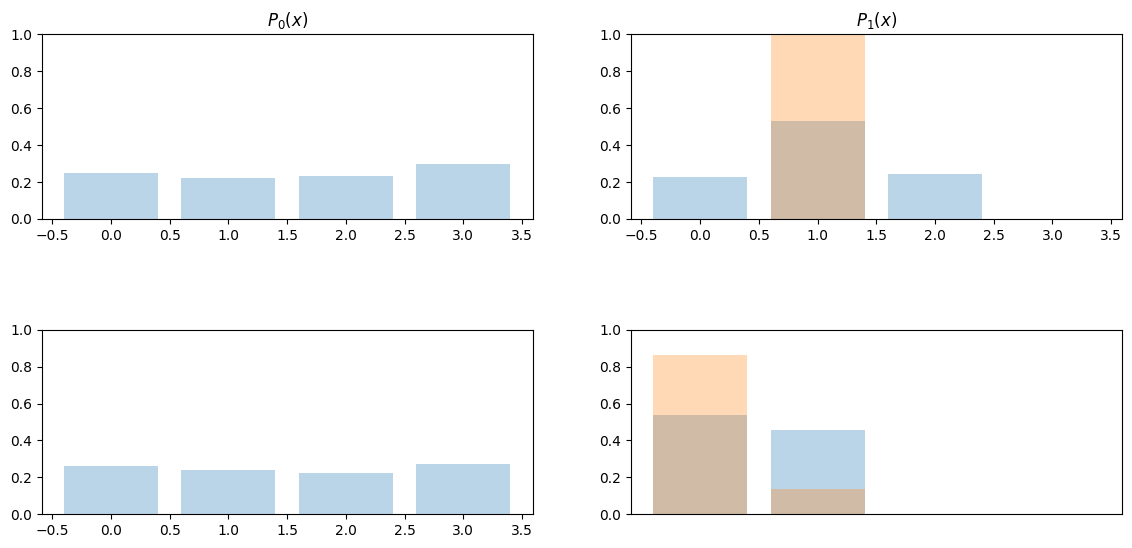

In [82]:
crm_trainer = CRMTrainer(crm.config, experiment_files=experiment_files,crm=crm)
results_, all_metrics = crm_trainer.train()

### Train Backwards

# ==================================================
# START OF TRAINING 
# ==================================================
# Current Model ************************************
colors_log_likelihood
prenzlauer_experiment
backward
# ==================================================
# Number of Epochs 200
# ==================================================


Epoch 200, Loss: 1.3520: 100%|██████████| 200/200 [02:16<00:00,  1.46it/s]
100it [00:00, 368.46it/s]
100it [00:00, 290.29it/s]


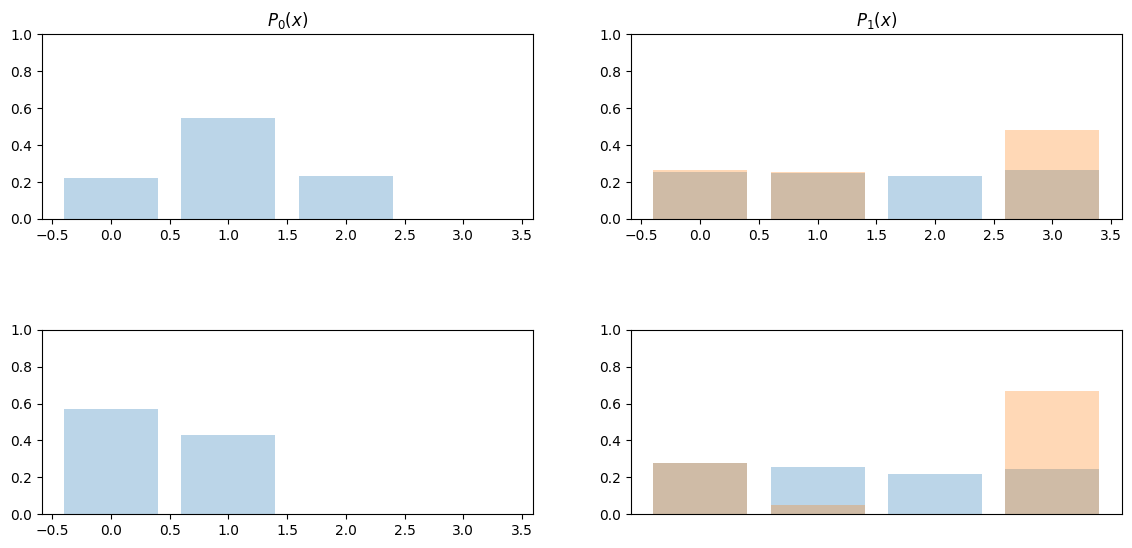

In [83]:
crm_trainer_b = CRMTrainer(crm_b.config, experiment_files=experiment_files_b,crm=crm_b)
results_, all_metrics = crm_trainer_b.train()

100it [00:00, 715.52it/s]
100it [00:00, 667.53it/s]
100it [00:00, 734.16it/s]
100it [00:00, 608.61it/s]


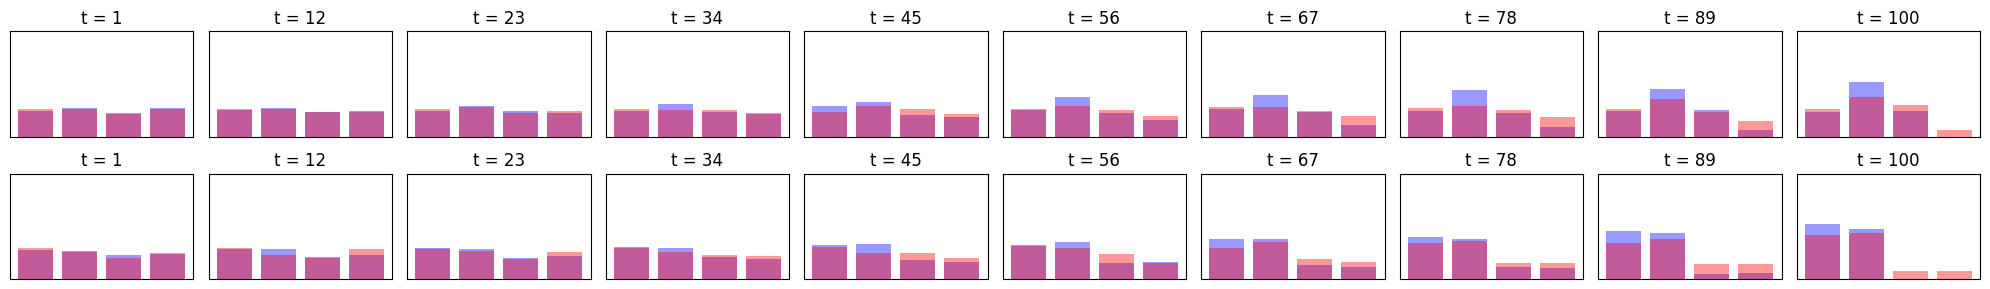

array([ 0, 11, 22, 33, 44, 55, 66, 77, 88, 99])

In [84]:
x_f, x_path, t_path = crm.pipeline(sample_size=500,return_path=True)
generative_histogram = categorical_counts_per_path(x_path,dimensions=dimensions,vocab_size=vocab_size,normalize=True)
plot_time_series_histograms(conditional_histograms_paths,generative_histogram,num_timesteps_to_plot=10,figsize_tuple=(20, 3),plot_path=None)

In [85]:
generative_histogram[-1,:,:]

tensor([[0.2580, 0.4280, 0.2580, 0.0560],
        [0.4180, 0.4540, 0.0620, 0.0660]])

In [87]:
crm.config.data1.bernoulli_probability

[[[0.22952337563037872,
   0.5267442464828491,
   0.24344582855701447,
   0.000286526745185256],
  [0.5485062599182129,
   0.44988977909088135,
   9.73582928054384e-07,
   0.0016030115075409412]]]

### Plot forward vs flipped backwards

100it [00:00, 734.34it/s]
100it [00:00, 679.20it/s]
100it [00:00, 625.69it/s]
100it [00:00, 811.52it/s]


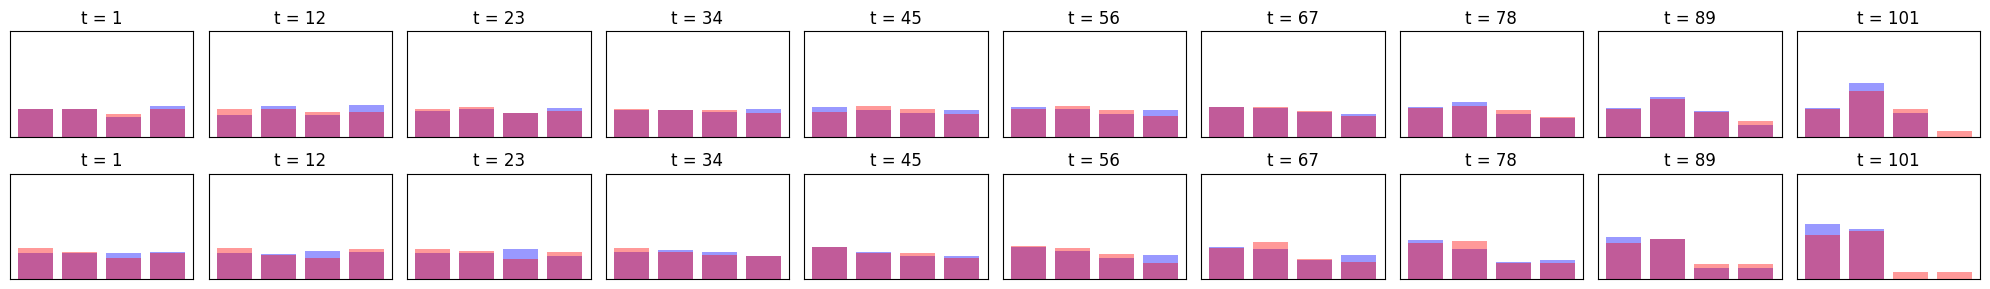

array([  0,  11,  22,  33,  44,  55,  66,  77,  88, 100])

In [88]:
x_f, x_path_b, t_path_b = crm_b.pipeline(sample_size=500,return_path=True)
generative_histogram_b = categorical_counts_per_path(x_path_b,dimensions=dimensions,vocab_size=vocab_size,normalize=True)
plot_time_series_histograms(torch.flip(generative_histogram_b,dims=[0]),generative_histogram,num_timesteps_to_plot=10,figsize_tuple=(20, 3),plot_path=None)

# Likelihood

In [ ]:
#NMC = 100

ignore_ = 1
databatch1 = next(crm.dataloader_1.train().__iter__())
x_1 = databatch1[0]

databatch0 = next(crm.dataloader_0.train().__iter__())
x_0 = databatch0[0]

batch_size = x_1.shape[0]
#x_1 = torch.repeat_interleave(x_1,NMC,dim=0)

In [9]:
get_log_likelihood(crm,crm_b)

20it [00:00, 539.52it/s]
20it [00:00, 426.12it/s]
20it [00:00, 262.81it/s]
20it [00:00, 347.70it/s]
20it [00:00, 325.17it/s]
20it [00:00, 305.79it/s]
20it [00:00, 366.37it/s]
20it [00:00, 303.58it/s]
20it [00:00, 295.60it/s]


tensor(0.3557, grad_fn=<DivBackward0>)